# Understanding and Predicting Stroke Events using Clinical Features

## Heathcare Data Science and Analytics
***

## Table of Contents
### The Problem
- [Signifying the Importance of Predicting a Stoke Event](#problem)

### Data Quality Check
- [Simple Inspection of Data](#datacleaning)

### Descriptive Statistics
- [Summary Statistics, Stroke Rate, Size of Data](#descriptive_statistics)
- [Correlation Matrix](#correlation_matrix)

### Exploratory Data Analysis (EDA)
- [Employee Satisfaction, Evaluation, and Project Count Distribution](#eda1)
- [Employee Satisfaction VS Evaluation](#eda2)
- [K Means Clustering of Employee](#clustering)
- [Employee Satisfaction Distribution](#satisfaction)
- [Employee Project Count Distribution](#project_count)
- [Employee Average Monthly Hours Distribution](#avghours)

### Simple Pre-Processing
- [Pre-Processing: Categorical and Numerical Variable](#pre_processing)

### Class Imbalance
- [How to Treat Class Imbalance Problems](#class_imbalance)

### Split Train/Test Set
- [Splitting the Data into Train/Test Sets](#train_test_split)

### Resample Techniques to Treat Imbalance Data
- [Evaluate Original, Upsampled, and Downsampled Data Metrics](#resample)
- [Choose Which Sampling Technique to Use For Model - Upsampling](#upsampling)

### Train/Test Model Perfomance with 5-Fold CV
- [Logistic Regression Classifier](#lr)
- [Random Forest Classifier](#rf)
- [Support Vector Classifier](#svc)

### Evaluation Metric (F1 Score & ROC/AUC)
- [ROC and AUC](#roc)
- [Feature Importance](#feature_importance)

### Conclusion
- [Retention Plan](#retention_plan)




***
### Objectives: 
- To understand what factors contributed most to a patient getting a stroke.

- To perform clustering to find any meaningful patterns of clinical features.

- To create a model that predicts the likelihood of a patient getting a stroke.

- To create or improve different prevention strategies on targeted patients. 

The implementation of this model will allow healthcare professionals to create better decision-making actions.

### I will be covering:
1. Descriptive Analytics - What happened?
2. Predictive Analytics - What might happen?
3. Prescriptive Analytics - What should we do?

<a id='problem'></a>
### The Problem:

The World Heath Organisation (WHO) have identified strokes as being the **2nd** leading cause of death globally.

Stokes are responsible for approximately **11%** of total deaths.


# Import Packages
***

In [2]:
__author__ = "Sophia Bouchama"
__copyright__ = "Copyright 2021. Sophia Bouchama"
__email__ = "hello@sophiabouchama.com"

In [3]:
# Import the neccessary modules for data manipulation and visual representation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
%matplotlib inline

# Read the Data
***
Reading in the CSV file.
Drop the 'id' column since ID is used for unique patient identification and provides us with no useful insights or meaningful information.

In [4]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv').drop(columns='id')

In [5]:
# Examine the dataset
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


<a id='datacleaning'></a>
# Data Quality Check
***

In [6]:
# Check to see if there are any missing values in our data set
df.isnull().any()

gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                   True
smoking_status       False
stroke               False
dtype: bool

In [7]:
# Check to see if there are any unmeaningful categorical values in our data set
columns = df[['gender', 'smoking_status', 'work_type', 'ever_married', 'Residence_type']]
for column in columns:    
    print(column,':\n',df[column].value_counts(),'\n')

gender :
 Female    2994
Male      2115
Other        1
Name: gender, dtype: int64 

smoking_status :
 never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64 

work_type :
 Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64 

ever_married :
 Yes    3353
No     1757
Name: ever_married, dtype: int64 

Residence_type :
 Urban    2596
Rural    2514
Name: Residence_type, dtype: int64 



In [8]:
# Check the type of our features to examine if there are any data inconsistencies
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
gender               5110 non-null object
age                  5110 non-null float64
hypertension         5110 non-null int64
heart_disease        5110 non-null int64
ever_married         5110 non-null object
work_type            5110 non-null object
Residence_type       5110 non-null object
avg_glucose_level    5110 non-null float64
bmi                  4909 non-null float64
smoking_status       5110 non-null object
stroke               5110 non-null int64
dtypes: float64(3), int64(3), object(5)
memory usage: 439.2+ KB


<a id='Missing Data'></a>
# Missing Data

### 1) BMI (Numerical Variable)

The 'bmi' column is the only numerical attribute with missing data, consisting of 201 null (NaN) values. 

We can calulate that 3.93% of the BMI data is missing:

Percentage of values missing = number of missing values / (number of missing values + number of present values) * 100

In [10]:
# Calculating how many BMI values are present and missing
df['bmi'].isnull().value_counts()

False    4909
True      201
Name: bmi, dtype: int64

In [11]:
# Calculating percentage of missing BMI values and round to 2dp
missing_vals = df['bmi'].isnull().sum()
present_vals = len(df) - df['bmi'].isnull().sum()

missing_bmi_values = (missing_vals / (missing_vals + present_vals)) * 100

missing_bmi_values.round(2)

3.93

In order to deal with the missing values, I will replace the missing data with the average value.
Replacing missing values will have some impact on the data by reducing the accuracy. However, since the percentage of missing values is small, this will have a small effect. This would be the better solution than to drop the column completely since BMI could have a significant impact on the causation of stroke.

In [12]:
# Replace missing BMI values with the mean
mean_bmi = df['bmi'].mean()
df['bmi'].replace(np.nan, mean_bmi, inplace=True)

df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


### 2) Gender (Categorical Variable)

The 'gender' column consists of 3 unique values: Male, Female and Other. Since there is only 1 patient categorised as 'Other' this row will be dropped since the size is very small and insignfificant to the dataset.


In [13]:
df = df[df['gender'] != 'Other']

### 3) Smoking Status (Categorical Variable)

The 'smoking status' column consists of 4 unqiue values: never smoked, smokes, formerly smoked and unknown. Since a large proportion of the class is 'unknown' (1544 patients), it will be kept as 'unknown' category and not dropped.

<a id='descriptive_statistics'></a>
# Exploratory Data Analysis
***

In [14]:
# How many patients are in the dataset?
df.shape

(5109, 11)

In [15]:
# Calculate the stroke rate of the healthcare dataset.
stroke_rate = df.stroke.value_counts() / df.shape[0]
stroke_rate

0    0.951262
1    0.048738
Name: stroke, dtype: float64

We can see that there is a large class imbalance:

- Approx 95% of the data are in the non-stroke class

- Approx 5% of the data are in the stroke class

In [16]:
# Display the statistical overview of the patients (numerical data)
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000
mean,43.229986,0.097475,0.054022,106.140399,28.894508,0.048738
std,22.613575,0.296633,0.226084,45.285004,7.698235,0.215340
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.240000,23.800000,0.000000
50%,45.000000,0.000000,0.000000,91.880000,28.400000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,32.800000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [17]:
# Display the mean summary of patients (Stroke V.S. Non-Stroke). What do you notice between the groups?
stroke_summary = df.groupby('stroke')
stroke_summary.mean()

,age,hypertension,heart_disease,avg_glucose_level,bmi
stroke,,,,,
0,41.974831,0.088889,0.047119,104.787584,28.826710
1,67.728193,0.265060,0.188755,132.544739,30.217789


In [18]:
stroke_summary.std()

,age,hypertension,heart_disease,avg_glucose_level,bmi
stroke,,,,,
0,22.293056,0.284613,0.211916,43.847095,7.776457
1,12.727419,0.442254,0.392102,61.921056,5.825589


### Data Normalisation ???

There are 3 numerical attributes in the dataset: age, average glucose level and bmi, which have different ranges. In order to create a fairer compariason and ensure equal weighting, data normalisation is performed to make statistical analysis and computation more consistent.

To preserve the original data, new columns are created instead of replacing the than replacing the initial columns: norm_age, norm_avg_glucose_level, norm_bmi.

Normalisation method - Min-Max:

In [253]:
columns = df[['age', 'avg_glucose_level', 'bmi']]

for column in columns:
    df[str('norm_'+column)]=(df[column]-df[column].min()) / (df[column].max()-df[column].min())
    
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,norm_age,norm_avg_glucose_level,norm_bmi
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1,0.816895,0.801265,0.301260
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1,0.743652,0.679023,0.212981
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1,0.975586,0.234512,0.254296
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1,0.597168,0.536008,0.276060
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1,0.963379,0.549349,0.156930


<a id='correlation_matrix'></a>
### Correlation Matrix

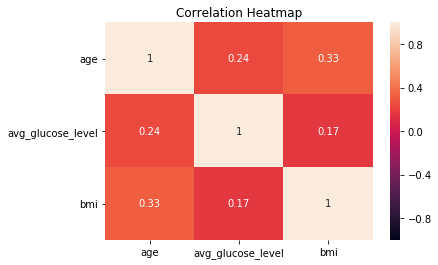

In [19]:
# Create the correlation matrix heatmap. What features correlate the most with stroke? What other correlations did you find?
corr = df[['age', 'avg_glucose_level', 'bmi']].corr()
heatmap = sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, vmin=-1, vmax=1, annot=True)
# Set the title
heatmap.set_title('Correlation Heatmap');



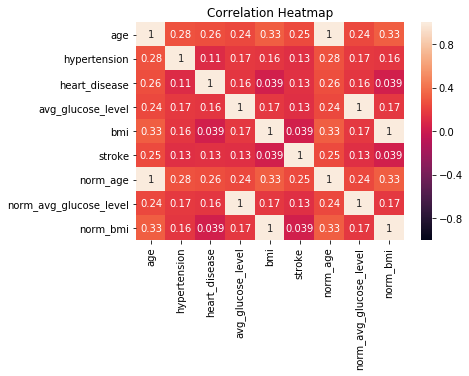

In [235]:
# Create the correlation matrix heatmap. What features correlate the most with stroke? What other correlations did you find?
corr = df.corr()
heatmap = sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, vmin=-1, vmax=1, annot=True)
# Set the title
heatmap.set_title('Correlation Heatmap');


<a id='eda1'></a>
# EDA 1. 
## Distribution of Clinical Patient Data

Text(0,0.5,'Patient Count')

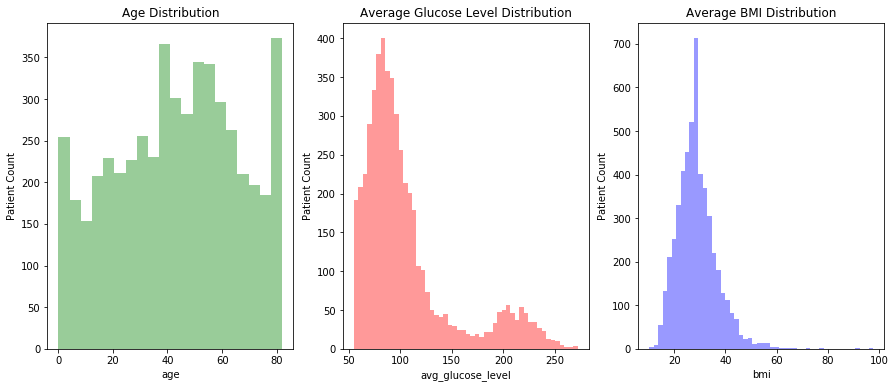

In [258]:
# Plot the distribution of clinical patient data: age, average glucose level and BMI. What story can you tell?

# Set up the matplotlib figure
f, axes = plt.subplots(ncols=3, figsize=(15, 6))

# Graph Age Distribution
sns.distplot(df.age, kde=False, color="g", ax=axes[0]).set_title('Age Distribution')
axes[0].set_ylabel('Patient Count')

# Graph Average Glucose Level Distribution
sns.distplot(df.avg_glucose_level, kde=False, color="r", ax=axes[1]).set_title('Average Glucose Level Distribution')
axes[1].set_ylabel('Patient Count')

# Graph Average BMI Distribution
sns.distplot(df.bmi, kde=False, color="b", ax=axes[2]).set_title('Average BMI Distribution')
axes[2].set_ylabel('Patient Count')

<a id='eda2'></a>
# EDA 2.
## Satisfaction VS Evaluation

- There are **3** distinct clusters for employees who left the company
 
**Cluster 1 (Hard-working and Sad Employee):** Satisfaction was below 0.2 and evaluations were greater than 0.75. Which could be a good indication that employees who left the company were good workers but felt horrible at their job. 
 - **Question:** What could be the reason for feeling so horrible when you are highly evaluated? Could it be working too hard? Could this cluster mean employees who are "overworked"?

**Cluster 2 (Bad and Sad Employee):** Satisfaction between about 0.35~0.45 and evaluations below ~0.58. This could be seen as employees who were badly evaluated and felt bad at work.
 - **Question:** Could this cluster mean employees who "under-performed"?

**Cluster 3 (Hard-working and Happy Employee):** Satisfaction between 0.7~1.0 and evaluations were greater than 0.8. Which could mean that employees in this cluster were "ideal". They loved their work and were evaluated highly for their performance. 
 - **Question:** Could this cluser mean that employees left because they found another job opportunity?

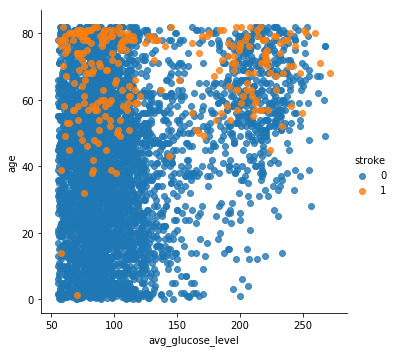

In [262]:
sns.lmplot(x='avg_glucose_level', y='age', data=df,
           fit_reg=False, # No regression line
           hue='stroke')   # Color by evolution stage

<a id='clustering'></a>
##  K-Means Clustering of Employee Turnover
***
**Cluster 1 (Blue):** Hard-working and Sad Employees

**Cluster 2 (Red):** Bad and Sad Employee 

**Cluster 3 (Green):** Hard-working and Happy Employee 

In [ ]:
# Import KMeans Model
from sklearn.cluster import KMeans

# Graph and create 3 clusters of Employee Turnover
kmeans = KMeans(n_clusters=3,random_state=2)
kmeans.fit(df[df.turnover==1][["satisfaction","evaluation"]])

kmeans_colors = ['green' if c == 0 else 'blue' if c == 2 else 'red' for c in kmeans.labels_]

fig = plt.figure(figsize=(10, 6))
plt.scatter(x="satisfaction",y="evaluation", data=df[df.turnover==1],
            alpha=0.25,color = kmeans_colors)
plt.xlabel("Satisfaction")
plt.ylabel("Evaluation")
plt.scatter(x=kmeans.cluster_centers_[:,0],y=kmeans.cluster_centers_[:,1],color="black",marker="X",s=100)
plt.title("Clusters of Employee Turnover")
plt.show()

<a id='satisfaction'></a>
# EDA 3. Employee Satisfaction

There is a **tri-modal** distribution for employees that turnovered
- Employees who had really low satisfaction levels **(0.2 or less)** left the company more
- Employees who had low satisfaction levels **(0.3~0.5)** left the company more
- Employees who had really high satisfaction levels **(0.7 or more)** left the company more

In [ ]:
#KDEPlot: Kernel Density Estimate Plot
fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(df.loc[(df['turnover'] == 0),'satisfaction'] , color='b',shade=True, label='no turnover')
ax=sns.kdeplot(df.loc[(df['turnover'] == 1),'satisfaction'] , color='r',shade=True, label='turnover')
plt.title('Employee Satisfaction Distribution - Turnover V.S. No Turnover')

<a id='project_count'></a>
# EDA 4. Employee Project Count 

Summary: 
- More than half of the employees with **2,6, and 7** projects left the company
- Majority of the employees who did not leave the company had **3,4, and 5** projects
- All of the employees with **7** projects left the company
- There is an increase in employee turnover rate as project count increases

In [ ]:
ax = sns.barplot(x="projectCount", y="projectCount", hue="turnover", data=df, estimator=lambda x: len(x) / len(df) * 100)
ax.set(ylabel="Percent")

<a id='department'></a>
# EDA 5. Employee Department Distribution

In [ ]:
hrleft = df[df['turnover']==1]

hrleft = pd.DataFrame(hrleft.department.value_counts()).reset_index()
hrstay = pd.DataFrame(df.department.value_counts()).reset_index()

hr_merge = pd.merge(hrleft, hrstay, how='inner', on='index')

hr_merge = hr_merge.rename(columns={"department_x":'left', "department_y":'stay', "index":'department' })
hr_merge

In [ ]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(13, 7))

# Plot the total schools per city
sns.set_color_codes("pastel")
sns.barplot(x="stay", y='department', data=hr_merge,
            label="Total", color="b")

# Plot the total community schools per city
sns.set_color_codes("muted")
sns.barplot(x="left", y="department", data=hr_merge,
            label="Left", color="r")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set( ylabel="Department", title='Employees Per Department',
       xlabel="# of Employees")
sns.despine(left=True, bottom=True)

<a id='avghours'></a>
# EDA 5. Average Monthly Hours

**Summary:** 
 - A bi-modal distribution for employees that turnovered 
 - Employees who had less hours of work **(~150hours or less)** left the company more
 - Employees who had too many hours of work **(~250 or more)** left the company 
 - Employees who left generally were **underworked** or **overworked**.


In [ ]:
#KDEPlot: Kernel Density Estimate Plot
fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(df.loc[(df['turnover'] == 0),'averageMonthlyHours'] , color='b',shade=True, label='no turnover')
ax=sns.kdeplot(df.loc[(df['turnover'] == 1),'averageMonthlyHours'] , color='r',shade=True, label='turnover')
ax.set(xlabel='Employee Average Monthly Hours', ylabel='Frequency')
plt.title('Employee AverageMonthly Hours Distribution - Turnover V.S. No Turnover')

<a id='pre_processing'></a>
# Pre-processing 
***

- Apply **get_dummies()** to the categorical variables.
- Seperate categorical variables and numeric variables, then combine them.

In [ ]:
cat_var = ['department','salary','turnover','promotion']
num_var = ['satisfaction','evaluation','projectCount','averageMonthlyHours','yearsAtCompany', 'workAccident']
categorical_df = pd.get_dummies(df[cat_var], drop_first=True)
numerical_df = df[num_var]

new_df = pd.concat([categorical_df,numerical_df], axis=1)
new_df.head()

<a id='class_imbalance'></a>
# Class Imbalance

### Employee Turnover Rate: 24%

In [ ]:
df.turnover.value_counts(1)

In [ ]:
plt.figure(figsize=(12,8))
turnover = df.turnover.value_counts()
sns.barplot(y=turnover.values, x=turnover.index, alpha=0.6)
plt.title('Distribution of Employee Turnover')
plt.xlabel('Employee Turnover', fontsize=16)
plt.ylabel('Count', fontsize=16)

# How to Treat Imbalanced Datasets

There are many ways of dealing with imbalanced data. We will focus in the following approaches:

1. Oversampling — SMOTE
2. Undersampling — RandomUnderSampler

<a id='train_test_split'></a>
# Split Train/Test Set
***

Let's split our data into a train and test set. We'll fit our model with the train set and leave our test set for our last evaluation.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix, precision_recall_curve

# Create the X and y set
X = new_df.iloc[:,1:]
y = new_df.iloc[:,0]

# Define train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=123, stratify=y)

<a id='resample'></a>
# Resample Methods

Let's train a base logistic regression model on the three types of samples to see which yields the best result:
1. **Orginal Sample**
2. **Upsampling Data**
3. **Downsampling Data**

<img src='https://api.ning.com/files/vvHEZw33BGqEUW8aBYm4epYJWOfSeUBPVQAsgz7aWaNe0pmDBsjgggBxsyq*8VU1FdBshuTDdL2-bp2ALs0E-0kpCV5kVdwu/imbdata.png'/>

In [ ]:
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE 

# Upsample minority class
X_train_u, y_train_u = resample(X_train[y_train == 1],
                                y_train[y_train == 1],
                                replace=True,
                                n_samples=X_train[y_train == 0].shape[0],
                                random_state=1)

X_train_u = np.concatenate((X_train[y_train == 0], X_train_u))
y_train_u = np.concatenate((y_train[y_train == 0], y_train_u))


# Upsample using SMOTE
sm = SMOTE(random_state=12, ratio = 1.0)
x_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)


# Downsample majority class
X_train_d, y_train_d = resample(X_train[y_train == 0],
                                y_train[y_train == 0],
                                replace=True,
                                n_samples=X_train[y_train == 1].shape[0],
                                random_state=1)
X_train_d = np.concatenate((X_train[y_train == 1], X_train_d))
y_train_d = np.concatenate((y_train[y_train == 1], y_train_d))


print("Original shape:", X_train.shape, y_train.shape)
print("Upsampled shape:", X_train_u.shape, y_train_u.shape)
print ("SMOTE sample shape:", x_train_sm.shape, y_train_sm.shape)
print("Downsampled shape:", X_train_d.shape, y_train_d.shape)

<a id='upsampling'></a>
# Choose Which Sampling Technique to Use For Model
***

### Apply 10-Fold Cross Validation for Logistic Regression
#### Train on Original, Upsampled, SMOTE, and Downsampled Data

**Objective**:Train our Logistic Regression Model to our **original, upsampled, and downsampled data** to see which performs best. 

**Resut:**
- **Original Sample**: F1 Score 44.96%
- **Upsample:** F1 Score 77.93%
- **SMOTE:** F1 Score 78.8%
- **Downsample:** F1 Score 77.85%

**SMOTE gives us the best performance**

## Upsample
You randomly resample the minority class to create new data. 

## SMOTE
You use the nearest neighbors of the minority observations to create new synthetic data

## Downsample
You remove some samples of the majority class

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# Create the Original, Upsampled, and Downsampled training sets
methods_data = {"Original": (X_train, y_train),
                "Upsampled": (X_train_u, y_train_u),
                "SMOTE":(x_train_sm, y_train_sm),
                "Downsampled": (X_train_d, y_train_d)}

# Loop through each type of training sets and apply 5-Fold CV using Logistic Regression
# By default in cross_val_score StratifiedCV is used
for method in methods_data.keys():
    lr_results = cross_val_score(LogisticRegression(), methods_data[method][0], methods_data[method][1], cv=5, scoring='f1')
    print(f"The best F1 Score for {method} data:")
    print (lr_results.mean())
 
cross_val_score(LogisticRegression(class_weight='balanced'), X_train, y_train, cv=5, scoring='f1').mean()

# Train Three Models
***

1. Logistic Regression
2. Random Forest
3. Support Vector Machine

<a id='lr'></a>
# Test Logistic Regression Performance
### Logistic Regression F1 Score (0.78)

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

lr = LogisticRegression()

# Fit the model to the Upsampling data
lr = lr.fit(x_train_sm, y_train_sm)

print ("\n\n ---Logistic Regression Model---")
lr_auc = roc_auc_score(y_test, lr.predict(X_test))

print ("Logistic Regression AUC = %2.2f" % lr_auc)

lr2 = lr.fit(x_train_sm, y_train_sm)
print(classification_report(y_test, lr.predict(X_test)))

<a id='rf'></a>
# Random Forest Classifier 
***

Notice how the random forest classifier takes a while to run on the dataset. That is one downside to the algorithm, it takes a lot of computation. But it has a better performance than the sipler models like Logistic Regression

### Apply 5-Fold Cross Validation for Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Model
rf = RandomForestClassifier()

rf_result = cross_val_score(rf, x_train_sm, y_train_sm, cv=5, scoring='f1')

rf_result.mean()

### Random Forest F1 Score (0.99)

In [ ]:
from sklearn.metrics import roc_auc_score

rf = rf.fit(x_train_sm, y_train_sm)

print ("\n\n ---Random Forest Model---")
rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
print ("Random Forest AUC = %2.2f" % rf_roc_auc)
print(classification_report(y_test, rf.predict(X_test)))

<a id='svc'></a>
# Gradient Boosting Classifier


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gbc = GradientBoostingClassifier()  

gbc = gbc.fit(x_train_sm,y_train_sm)

gbc

### Apply 5-Fold Cross Validation for Gradient Boosting Classifier

In [ ]:
gbc_result = cross_val_score(gbc, x_train_sm, y_train_sm, cv=5, scoring='f1')
gbc_result.mean()

### Gradient Boosting Classifier F1 Score (0.94)

In [ ]:
from sklearn.metrics import roc_auc_score

print ("\n\n ---Gradient Boosting Model---")
gbc_auc = roc_auc_score(y_test, gbc.predict(X_test))
print ("Gradient Boosting Classifier AUC = %2.2f" % gbc_auc)
print(classification_report(y_test, gbc.predict(X_test)))

<a id='roc'></a>
# ROC Graph

In [ ]:
rf.predict_proba(X_test)

In [ ]:
# Create ROC Graph
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
gbc_fpr, gbc_tpr, gbc_thresholds = roc_curve(y_test, gbc.predict_proba(X_test)[:,1])


plt.figure()

# Plot Logistic Regression ROC
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % lr_auc)

# Plot Random Forest ROC
plt.plot(rf_fpr, rf_tpr, label='Random Forest Classifier (area = %0.2f)' % rf_roc_auc)

# Plot Decision Tree ROC
plt.plot(gbc_fpr, gbc_tpr, label='Gradient Boosting Classifier (area = %0.2f)' % gbc_auc)

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Confusion Matrix for Linear Regresion
confusion_matrix(y_test, lr.predict(X_test))

In [ ]:
confusion_matrix(y_test, gbc.predict(X_test))

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, rf.predict(X_test))

# Recall or Precision?
***
It depends on how much cost/weight you want on your two types of errors: (1) **False Positives** or (2) **False Negatives**

What's the coset of having a FN and FP?


**Optimize Recall When:**
- You want to limit **false negatives**
- You will get more False Positives
- FN > FP
- Example: Predicting Cancer Patients or Credit Card Fraud

**Optimize Precision When:**
- You want to limit **false positives**
- FP > FN
- Example: Spam VS Not Spam

<a id='feature_importance'></a>
# Random Forest Feature Importances

In [ ]:
# Get Feature Importances
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances = feature_importances.reset_index()
feature_importances

In [ ]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(13, 7))

# Plot the Feature Importance
sns.set_color_codes("pastel")
sns.barplot(x="importance", y='index', data=feature_importances,
            label="Total", color="b")

# Apply Random Noise to Feature Importance

In [ ]:
# Apply Random Noise to data set
X_train_rnoise = pd.DataFrame(X_train)
X_train_rnoise['RANDOM_NOISE'] = np.random.normal(0, 1, X_train_rnoise.shape[0])

# Fit Random Forest to DataSet
rf_random = RandomForestClassifier()
rf_random = rf_random.fit(X_train_rnoise, y_train)

# Get Feature Importances
feature_importances_random = pd.DataFrame(rf_random.feature_importances_, index = X_train_rnoise.columns,columns=['importance']).sort_values('importance', ascending=False)
feature_importances_random = feature_importances_random.reset_index()

# Create Seaborn PLot
sns.set(style="whitegrid")
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(13, 7))


clrs = ['red' if (x == 5 ) else 'green' for x in feature_importances_random.index.values ]

# Plot the Feature Importance
sns.barplot(x="importance", y='index', data=feature_importances_random,
            label="Total",  palette=clrs)

In [ ]:
X_train_rnoise.head()

<a id='retention_plan'></a>
# Retention Plan

**Reference:** http://rupeshkhare.com/wp-content/uploads/2013/12/Employee-Attrition-Risk-Assessment-using-Logistic-Regression-Analysis.pdf

Since this model is being used for people, we should refrain from soley relying on the output of our model. Instead, we can use it's probability output and design our own system to treat each employee accordingly. 

1.	**Safe Zone (Green)** – Employees within this zone are considered safe. 
2.	**Low Risk Zone (Yellow)** – Employees within this zone are too be taken into consideration of potential turnover. This is more of a long-term track.
3.	**Medium Risk Zone (Orange)** – Employees within this zone are at risk of turnover. Action should be taken and monitored accordingly. 
4.	**High Risk Zone (Red)** – Employees within this zone are considered to have the highest chance of turnover. Action should be taken immediately. 

<img src="http://i64.tinypic.com/somk9s.jpg"/>

In [ ]:
rf.predict_proba(X_test)[175:225]

# What to Optimize

We want our machine learn model to capture as much of the minority class as possible (turnover group). Our objective is to catch ALL of the highly probable turnover employee at the risk of flagging some low-risk non-turnover employee. 

## Conclusion
**Binary Classification**: Turnover V.S. Non Turnover

**Instance Scoring**: Likelihood of employee responding to an offer/incentive to save them from leaving.

**Need for Application**: Save employees from leaving

In our employee retention problem, rather than simply predicting whether an employee will leave the company within a certain time frame, we would much rather have an estimate of the probability that he/she will leave the company. 
We would rank employees by their probability of leaving, then allocate a limited incentive budget to the highest probability instances. 

Consider employee turnover domain where an employee is given treatment by Human  Resources because they think the employee will leave the company within a month, but the employee actually does not. This is a false positive. This mistake could be expensive, inconvenient, and time consuming for both the Human Resources and employee, but is a good investment for relational growth. 

Compare this with the opposite error, where Human Resources does not give treatment/incentives to the employees and they do leave. This is a false negative. This type of error is more detrimental because the company lost an employee, which could lead to great setbacks and more money to rehire. 
Depending on these errors, different costs are weighed based on the type of employee being treated. For example, if it’s a high-salary employee then would we need a costlier form of treatment? What if it’s a low-salary employee? The cost for each error is different and should be weighed accordingly. 
 
 **Solution 1:** 
 - We can rank employees by their probability of leaving, then allocate a limited incentive budget to the highest probability instances.
 - OR, we can allocate our incentive budget to the instances with the highest expected loss, for which we'll need the probability of turnover.

**Solution 2:** 
Develop learning programs for managers. Then use analytics to gauge their performance and measure progress. Some advice:
 - Be a good coach
 - Empower the team and do not micromanage
 - Express interest for team member success
 - Have clear vision / strategy for team
 - Help team with career development    

# Selection Bias
***

- One thing to note about this dataset is the turnover feature. We don't know if the employees that left are interns, contractors, full-time, or part-time. These are important variables to take into consideration when performing a machine learning algorithm to it. 

- Another thing to note down is the type of bias of the evaluation feature. Evaluation is heavily subjective, and can vary tremendously depending on who is the evaluator. If the employee knows the evaluator, then he/she will probably have a higher score. 

# Try It Out Yourself: IBM HR Data Set